I will use two files from 2017 in order to compare drop out rates to attendance. Chronicabsenteeis17 contains data on chronic absentees based on grade groupings by school. Dropouts17 contains the number of students who have dropped out by grade during that year. Adding those numbers for the corresponding grade grouping will allow me to compare chronic absenteeism to dropout rates. I could also look at overall poverty rate (school lunch data) for the year to see if the overall poverty rate for the school is correlated with the drop out rate.



In [52]:
#Creating DataFrame for Chronic Absentee data from 2017

import pandas as pd

df1 = pd.read_csv("chronicabsenteeism17.txt", delimiter= '\t', low_memory=False, on_bad_lines='skip', encoding = 'unicode_escape')
df1 = df1[df1['AggregateLevel'] == "S"]
df1 = df1[df1['ReportingCategory'] == "GR912"]

#df1 = df1.drop(['AggregateLevel', 'CountyCode', 'DistrictCode', 'SchoolCode', 'CountyName', 'CharterYN'], axis = 1)
df1 = df1.drop(['AggregateLevel', 'CountyName','DistrictName', 'SchoolName', 'CharterYN', 'ChronicAbsenteeismEligibleCumula', 'ChronicAbsenteeismCount'], axis = 1)

#creating the school number from country, district and school code
#getting rid of the blanks
df1 = df1[df1['CountyCode'].notnull()]
df1 = df1[df1['DistrictCode'].notnull()]
df1 = df1[df1['SchoolCode'].notnull()]

#ensuring the codes are the correct length
df1['DistrictCode'] = df1['DistrictCode'].astype(str)
#df1 = [df1['DistrictCode'].str.len() == 5]
df1['DistrictCode'] = df1['DistrictCode'].str[:-2]+"0"

df1['SchoolCode'] = df1['SchoolCode'].astype(str)
#df1 = df1[df1['SchoolCode'].str.len() == 7]
df1['SchoolCode'] = df1['SchoolCode'].str[:-2]

#codelength = (df1['DistrictCode'].str.len() == 5) & (df1['SchoolCode'].str.len() == 7)
#df1 = df1.loc[codelength]
              
df1['CDS_CODE'] = df1['CountyCode'].astype(str) + df1['DistrictCode'] + df1['SchoolCode']
df1 = df1.drop(['CountyCode', 'DistrictCode', 'SchoolCode'], axis = 1)

df1 = df1.rename(columns={"AcademicYear":"Academic Year", "DistrictName":"District Name", "SchoolName":"School Name", "ReportingCategory":"Reporting Category", "ChronicAbsenteeismRate":"Absentee Rate"})
df1 = df1[df1['Absentee Rate'].notnull()]

#reorder the columns with CDS CODE as Column 1
#df1 = df1[['CDS_CODE',
df1 = df1.sort_values('CDS_CODE')
df1['CDS_CODE'] = df1['CDS_CODE'].astype(str)
df1.to_csv('chronicabsenteeism17.csv', index = None)


In [54]:
df2 = pd.read_csv("filesdropouts17.txt", delimiter= '\t', low_memory=False, on_bad_lines='skip', encoding = 'unicode_escape')
#df1 = df1[df1['AggregateLevel'] == "S"]
df2 = df2.drop(['E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'EUS', 'D7', 'D8', 'DUS'], axis = 1)
#df1 = df1.rename(columns={"AcademicYear":"Academic Year", "DistrictName":"District Name", "SchoolName":"School Name", "ReportingCategory":"Reporting Category", "ChronicAbsenteeismEligibleCumula":"ChronicAbsenteeismEligibleCumulativeEnrollment"})
#df1 = df1[df1['ChronicAbsenteeismRate'].notnull()]
df2 = df2.sort_values('CDS_CODE')
df2['CDS_CODE'] = df2['CDS_CODE'].astype(str)
#enrolTOTdf = df2.groupby(by=['CDS_CODE']),['ETOT','DTOT'].sum().reset_index()
enrolTOTdf = df2.groupby(['CDS_CODE'])['ETOT'].sum()
dropTOTdf = df2.groupby(['CDS_CODE'])['DTOT'].sum()
df2 = pd.merge(enrolTOTdf, dropTOTdf, on = 'CDS_CODE')
#df2 = enrolTOTdf.to_frame().merge(dropTOTdf,on = 'CDS_CODE',how = 'outer')
#df_dtot = df2.groupby(['CDS_CODE'])['DTOT'].sum().reset_index()

# TODO remove ETOT = 0
df2 = df2[df2['ETOT'] != 0]



#merged_df = pd.merge(df1, df7[['School Name', 'Reporting Category', 'Graduate count']], on=['School Name', 'Reporting Category'], how='left')
df2.to_csv('dropouts17.csv', index = None)

In [46]:
dropTOTdf.head()

CDS_CODE
10101080109991    212
10101080111682      0
10101080119628      3
10101081030337    128
10101081030899     42
Name: DTOT, dtype: int64

In [23]:
#adding Dropout rate

import csv

with open('dropouts17.csv','r') as csvinput:
    with open('dropoutRates17.csv', 'w') as csvoutput:
        writer = csv.writer(csvoutput, lineterminator='\n')
        reader = csv.reader(csvinput)

        all = []
        row = next(reader)
        row.append('Dropout Rate')
        all.append(row)

        for row in reader:
            row.append(float(row[2])/float(row[1]))
            all.append(row)

        writer.writerows(all)

In [55]:
#Merge drop out rates with absenteeism
df3 = pd.read_csv('dropoutRates17.csv')
df3 = df3[df3['Dropout Rate'] <= 1]
#TODO make the rate non-decimal
#df3 = df3[df3['Dropout Rate'].astype(float)*100]
df1['CDS_CODE'] = df1['CDS_CODE'].astype(str)
df3['CDS_CODE'] = df3['CDS_CODE'].astype(str)

#merged_df = pd.concat([df1, df3], sort = False)
merged_df = pd.merge(df1, df3, on = 'CDS_CODE')
merged_df = merged_df.drop(['Academic Year', 'Reporting Category', 'ETOT', 'DTOT', 'CDS_CODE'], axis = 1)
merged_df = merged_df[['Absentee Rate', 'Dropout Rate']]
merged_df = merged_df.sort_values(by=['Absentee Rate'])
merged_df.to_csv('merged17.csv', index = None)

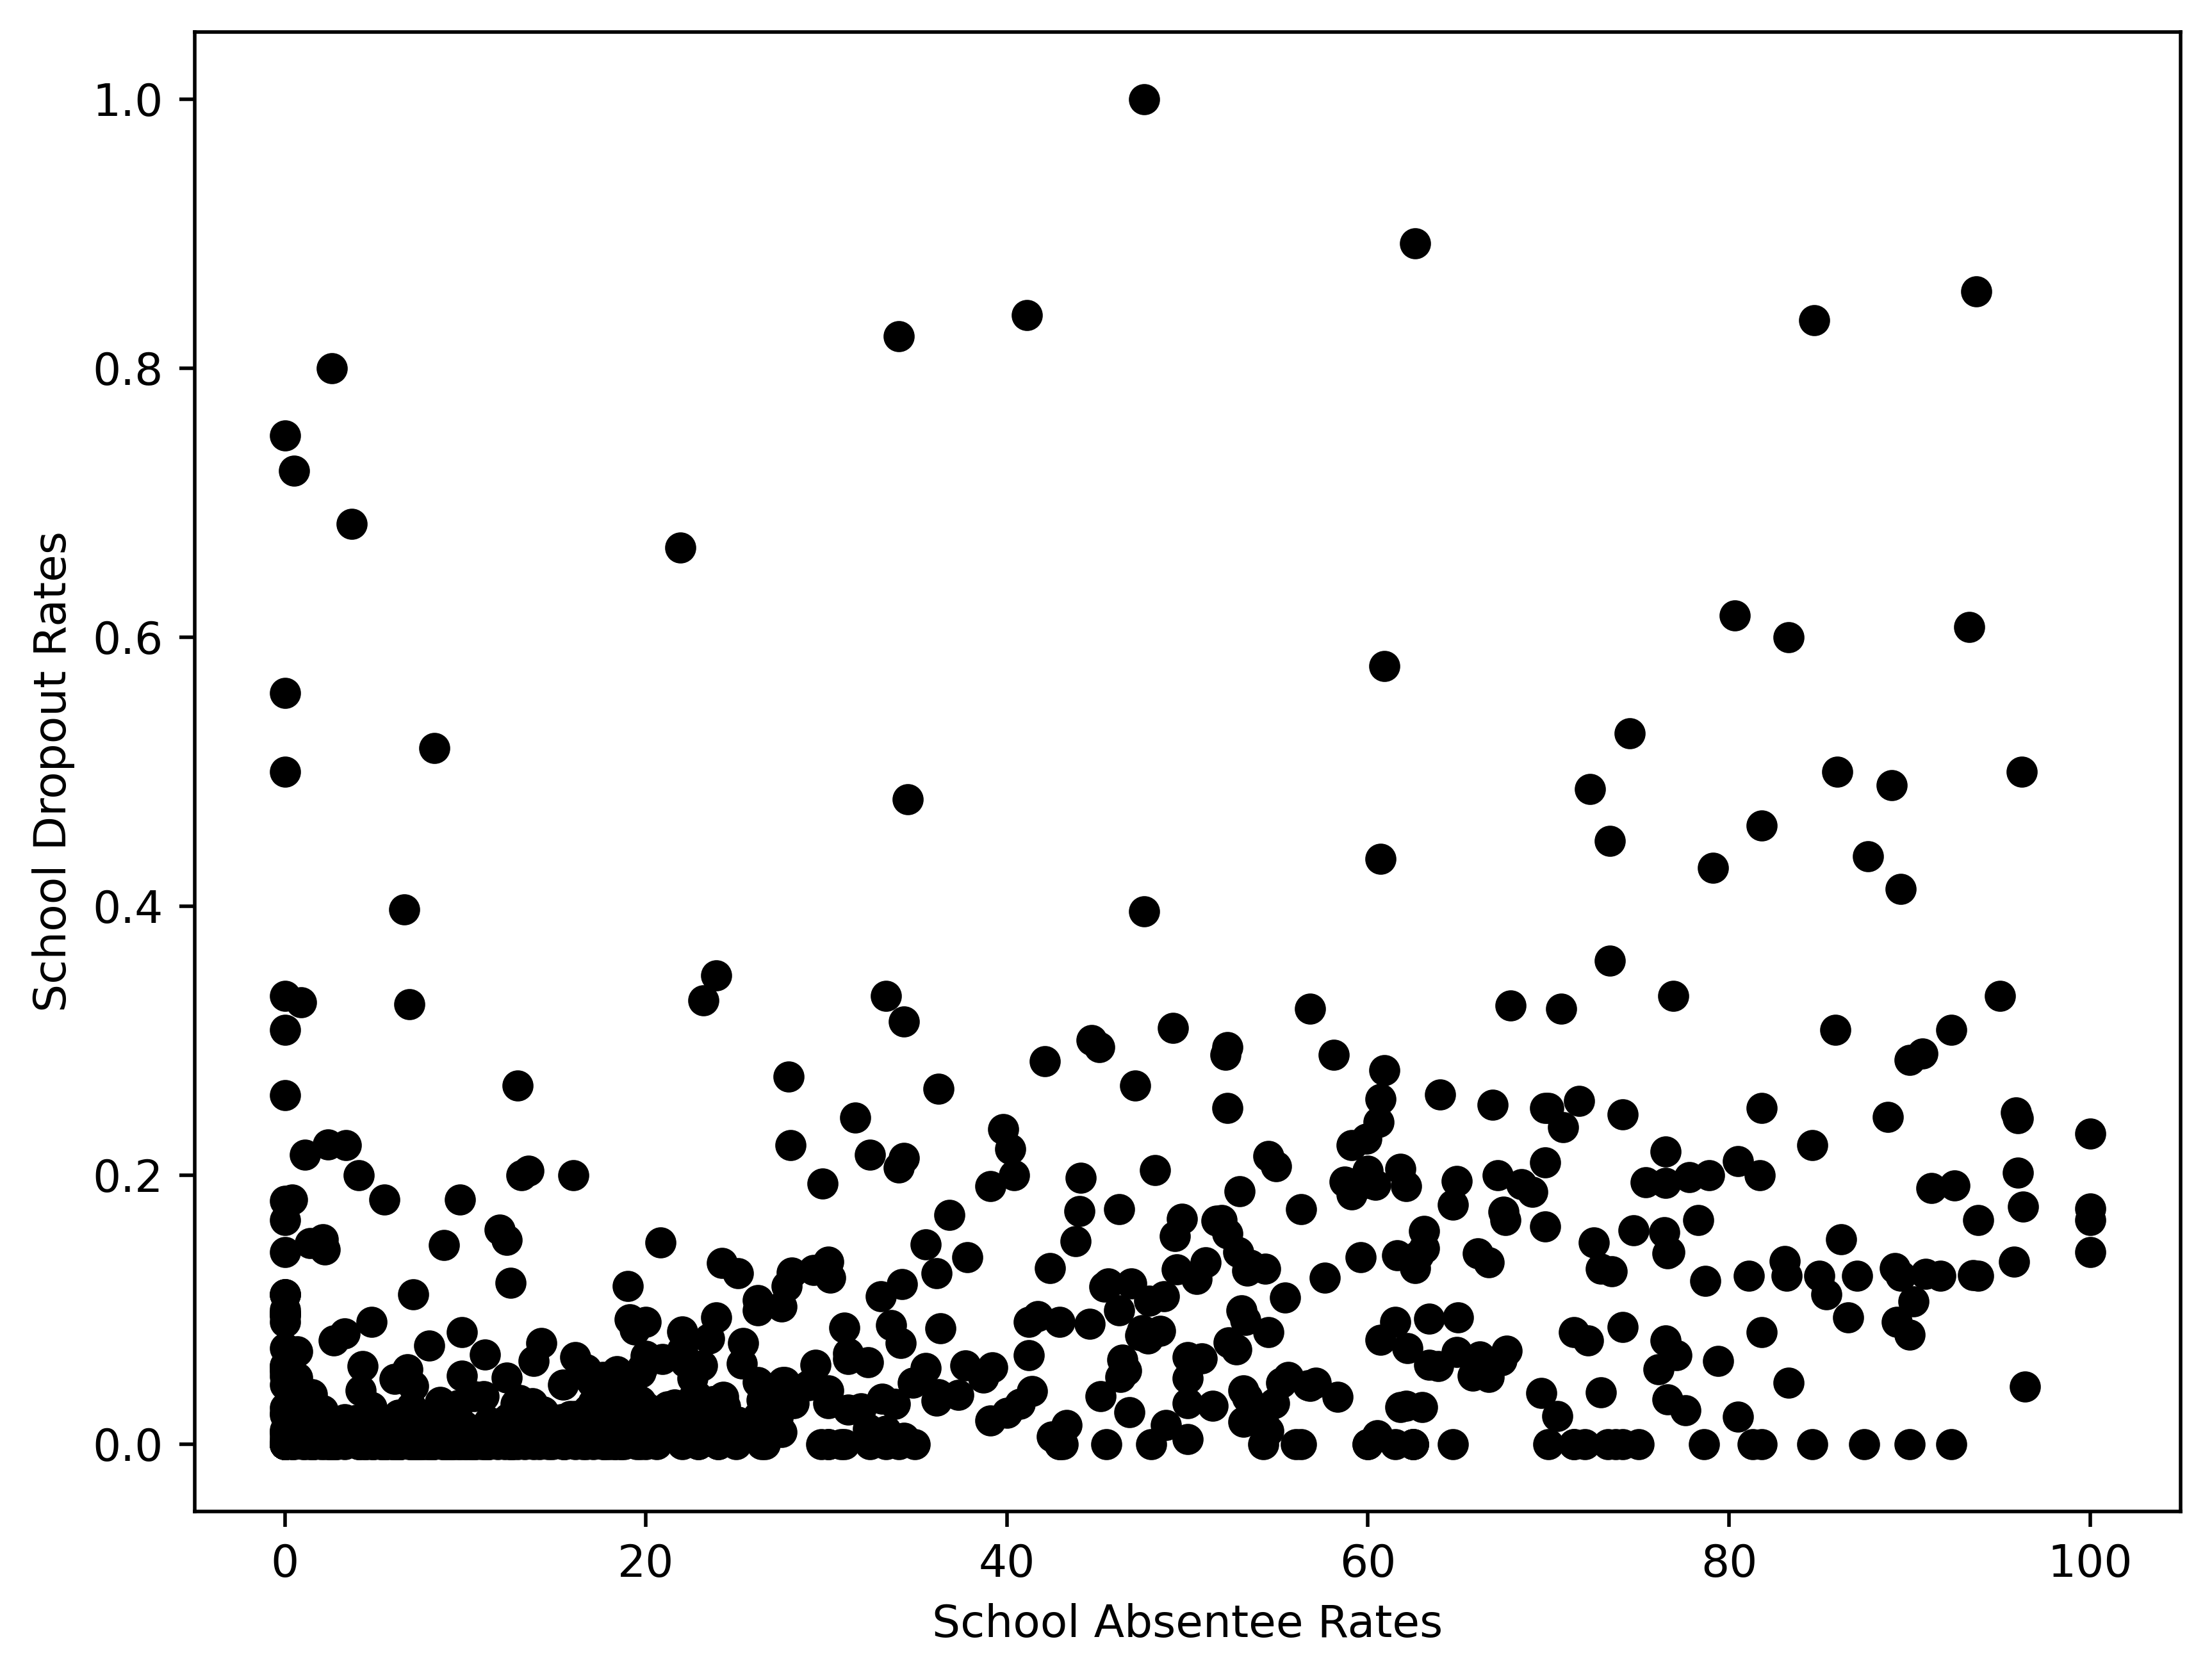

In [56]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import haversine_distances
import matplotlib.patches as patches

absentees = merged_df['Absentee Rate'].to_list()
dropouts = merged_df['Dropout Rate'].to_list()

plt.figure(figsize=(8,6), dpi = 500)
plt.plot(absentees, dropouts, 'ko')
plt.xlabel('School Absentee Rates')
plt.ylabel('School Dropout Rates')
plt.show()

In [57]:
def linear_regression_dropoutrisk(absenteerate, dropoutrate):
    
    '''
    Performs linear regression on the given absentee rates and dropout rates
    
    Args:
        absentee_rates: a list of absentee rates for various schools
        dropout_rates: a list of dropout rates for the same schools
    Returns:
        a tuple of the slope and the intercept of the linear regression line
    '''
    
    absentee_rate = np.array(absentees)
    dropout_rate = np.array(dropouts)
    
    #calculate mean values
    mean_absentee_rate = np.mean(absentee_rate)
    mean_dropout_rate = np.mean(dropout_rate)
    
    #numerator and demoninator for slope
    numerator = np.sum((absentee_rate - mean_absentee_rate) * (dropout_rate - mean_dropout_rate))
    denominator = np.sum((absentee_rate - mean_absentee_rate) **2)
    
    #slope
    m = numerator/denominator
    b = mean_dropout_rate - m * mean_absentee_rate
    
    return m,b

Slope (m): 0.002119 Percent School Dropouts/Percent School Absenteeism
Intercept (b): 0.014087


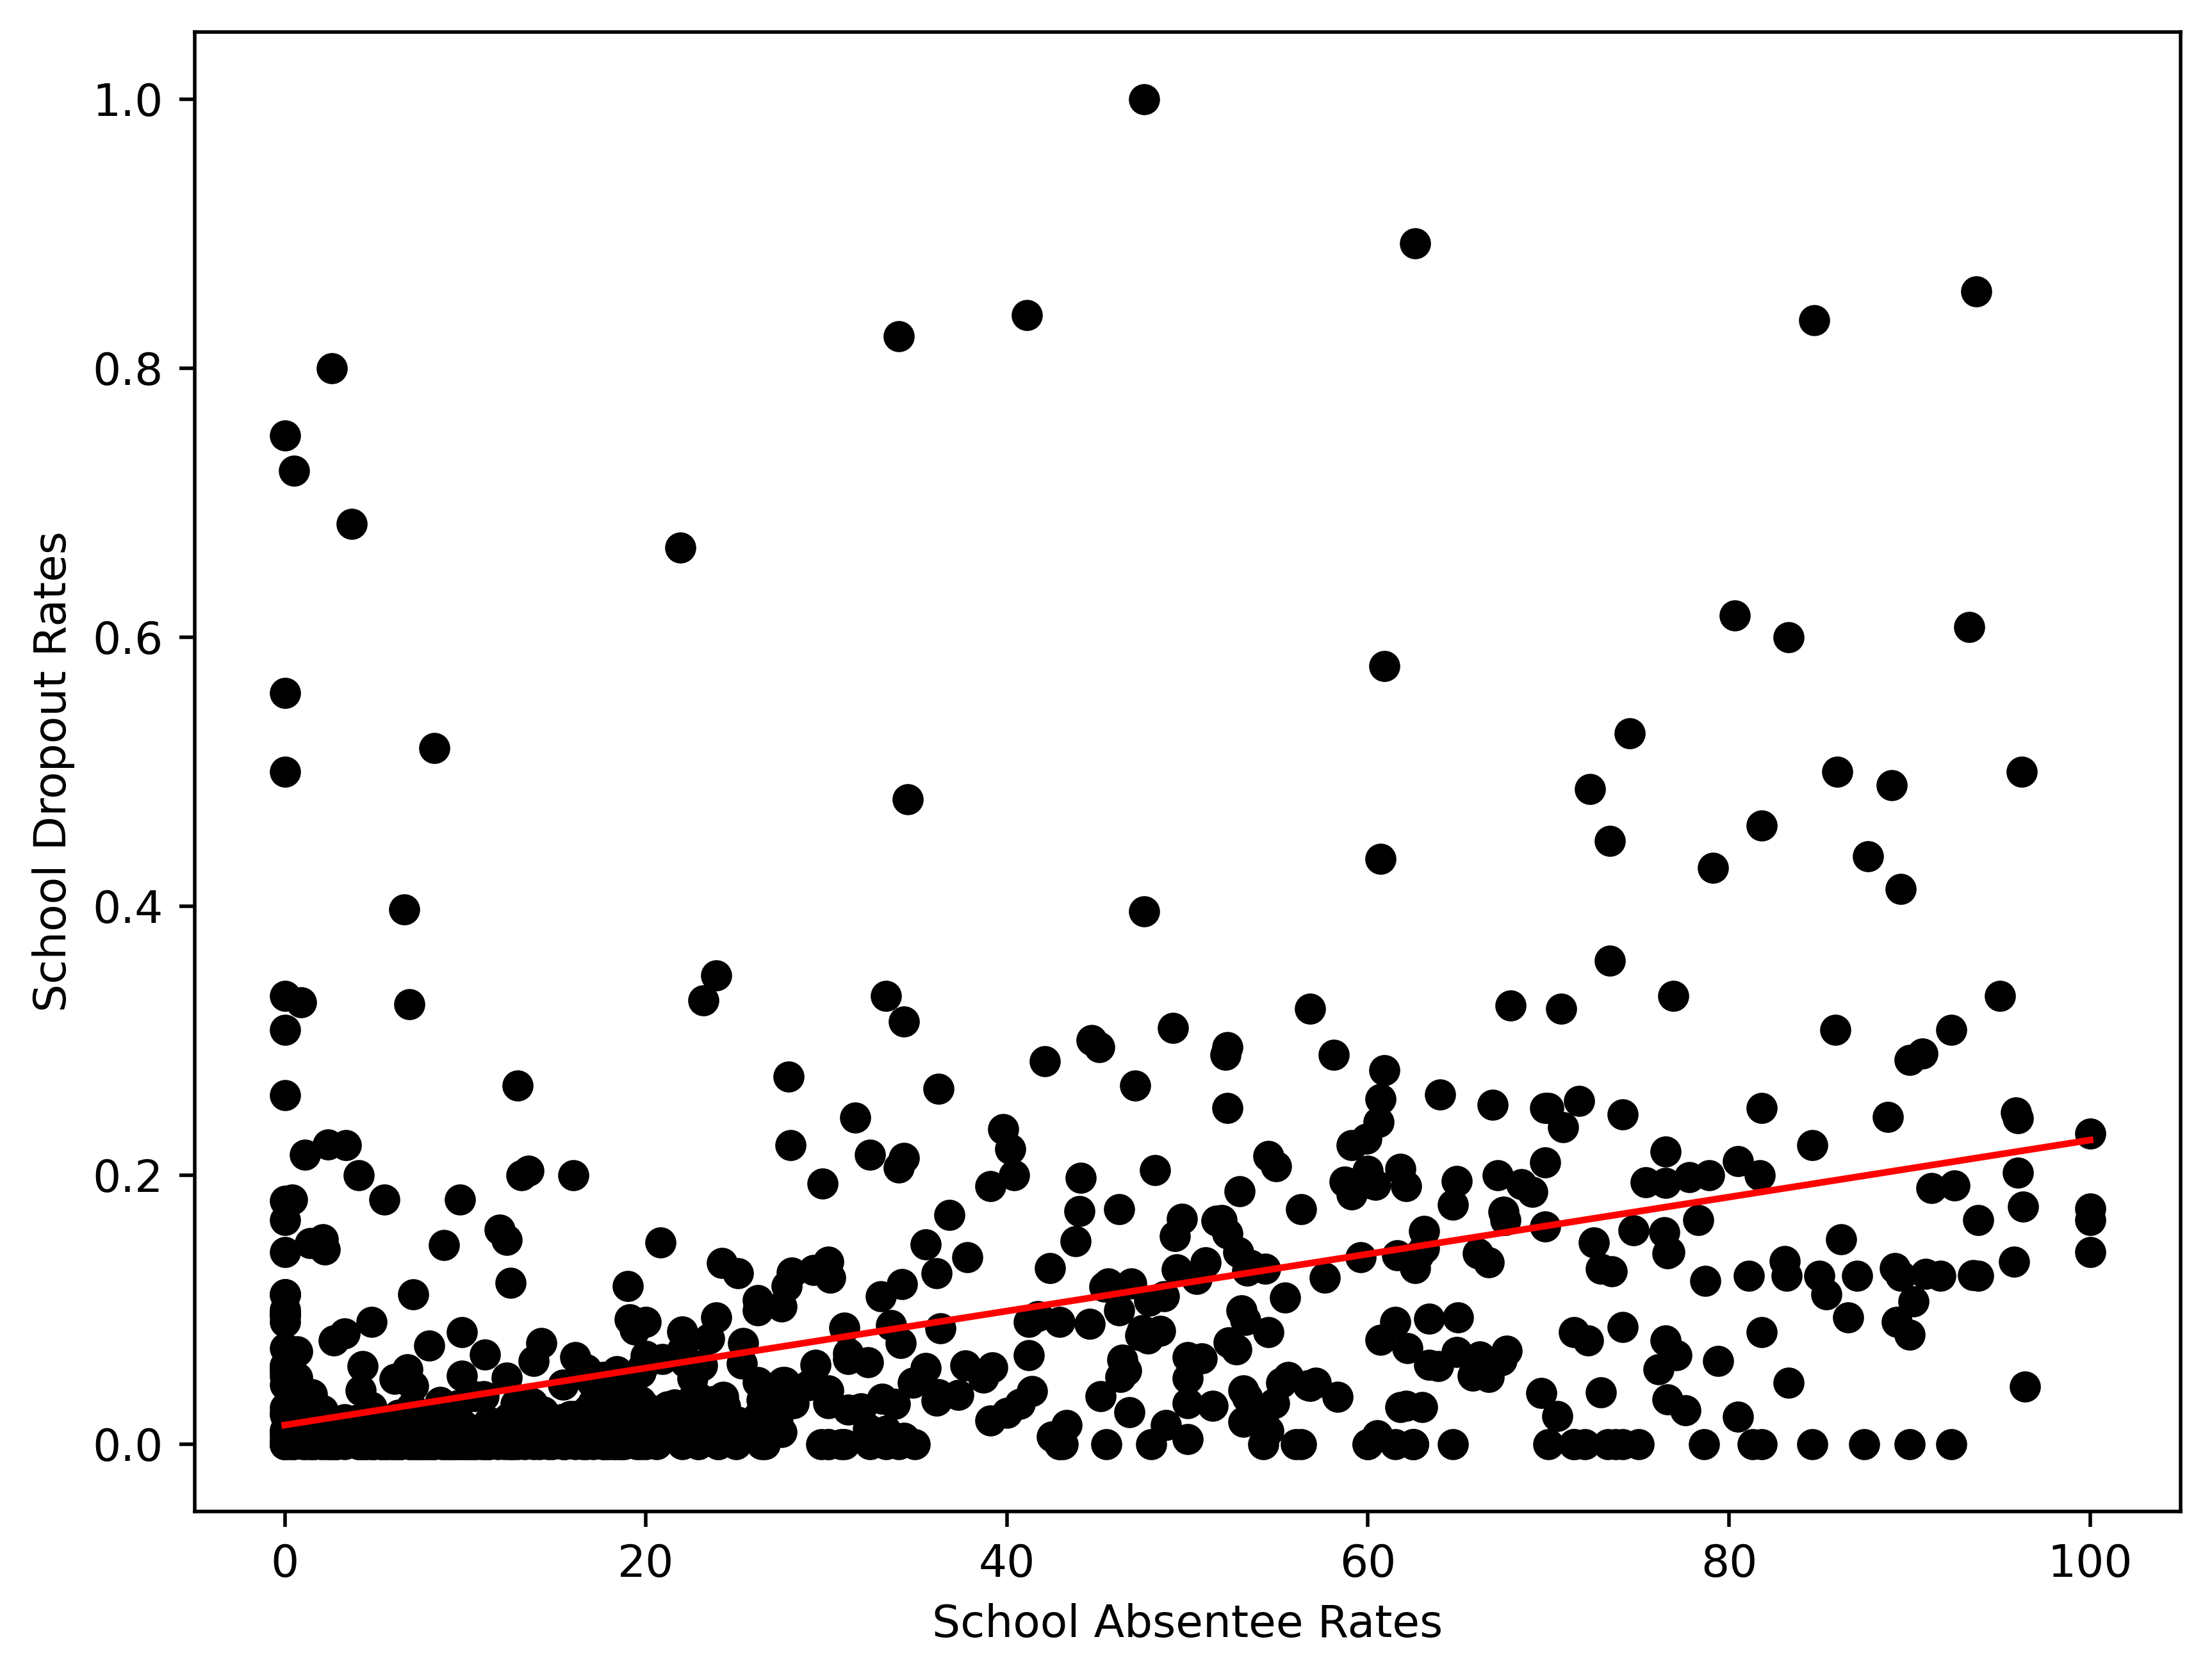

In [58]:
#Do linear regression
slope, intercept = linear_regression_dropoutrisk(absentees, dropouts)

#print slop and intercept for these data
print("Slope (m):", round(slope,6), 'Percent School Dropouts/Percent School Absenteeism')
print("Intercept (b):", round(intercept,6))

#arrays for the line
regression_x = np.array([np.min(absentees), np.max(absentees)])
regression_y = slope * regression_x + intercept

plt.figure(figsize=(8,6), dpi = 500)
plt.plot(absentees, dropouts, 'ko')
plt.plot(regression_x, regression_y,'r-')
plt.xlabel('School Absentee Rates')
plt.ylabel('School Dropout Rates')
plt.show()

In [6]:
import pandas as pd

df2 = pd.read_csv("filesdropouts17.txt", delimiter= '\t', low_memory=False, on_bad_lines='skip', encoding = 'unicode_escape')
df2.to_csv('dropouts.csv', index = None)

In [3]:
dfTest = pd.read_csv("chronicabsenteeism17.txt", delimiter= '\t', low_memory=False, on_bad_lines='skip', encoding = 'unicode_escape')

dfTest.to_csv('absentTest.csv', index = None)


In [59]:
dfPov = pd.read_excel("frpm1617.xls", sheet_name= "FRPM School-Level Data ")
dfPov = dfPov.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'], axis = 1)

dfPov = dfPov.rename(columns={"FRPM School-Level Data":"Academic Year", "Unnamed: 1":"County Code", "Unnamed: 2":"District Code", "Unnamed: 3":"School Code", "Unnamed: 21":"School Pov Rate"})

dfPov['CDS_CODE'] = dfPov['County Code'].astype(str) + dfPov['District Code'] + dfPov['School Code']
dfPov = dfPov.drop(['County Code', 'District Code', 'School Code'], axis = 1)

dfPov.to_csv('poverty17.csv', index = None)

In [60]:
#Merge Poverty with drop out rates and absenteeism

dfPov['CDS_CODE'] = dfPov['CDS_CODE'].astype(str)

#merged_df = pd.concat([df1, df3], sort = False)
new_merged_df = pd.read_csv("merged17.csv")
merged_df = merged_df.drop(['Academic Year', 'Reporting Category', 'ETOT', 'DTOT', 'CDS_CODE'], axis = 1)
#merged_df = merged_df[['Absentee Rate', 'Dropout Rate']]
#merged_df = merged_df.sort_values(by=['Absentee Rate'])
new_merged_df.to_csv('newmerged17.csv', index = None)

KeyError: "['Academic Year', 'Reporting Category', 'ETOT', 'DTOT', 'CDS_CODE'] not found in axis"